# 1.0.0 The Schapiro Task

This notebook summarizes all the components of this repo that implements what I've been calling Schapiro task as seen in her paper titled, "[Neural representations of events arise from temporal community structure](https://www.nature.com/articles/nn.3331)".

## Environment

These next few sections summarize the environment necessary. Skip if needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: apra-x3

Git hash: 1c0ef667d5e3b71d00623151556df26a75fd9806

Git branch: master



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

In [4]:
from collections.abc import Iterable

import networkx as nx
import numpy as np
import torch
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, IterableDataset

# Keep track of versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.18.1

networkx: 2.5
PIL     : 8.1.0
numpy   : 1.19.2
torch   : 1.7.1



## The Schapiro Graph

Recall the graph we want to create has the following structure:
    
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnn.3331/MediaObjects/41593_2013_Article_BFnn3331_Fig1_HTML.jpg?as=webp">

Where `Fig A` is the graph, and `Fig B` & `Fig C` are two different sets of elements that you sample from.

## Networkx Graph Structures

The underlying datastructure being used is the `networkx` `Graph` class. Below is a function to generate one pentagon of the overall graph.

In [5]:
def schapiro_pentagon(offset=0, weight=1):
    """Creates a pentagon of nodes and edges like in the paper.

    Nodes are numbered from ``offset*5`` to ``offset*5 + 5``.
    
    Parameters
    ----------
    offset : int (optional)
    	Offset to start the numbering of the nodes

    weight : int (optional)
    	Weight of edges.

    Returns
    -------
    G : nx.Graph
    	Graph that contains the nodes and edges for the pentagon
    """
    G = nx.Graph()
    G.add_nodes_from(range(offset, offset+5))

    nodes_list = list(G.nodes)
    border_nodes = [nodes_list[0], nodes_list[-1]]
    for i, node_1 in enumerate(nodes_list[:-1]):
        for node_2 in nodes_list[i+1:]:
            if node_1 in border_nodes and node_2 in border_nodes:
                continue
            G.add_edge(node_1, node_2, weight=weight)
    return G

G = schapiro_pentagon()

To visualize graphs, use the various `networkx` draw functions:

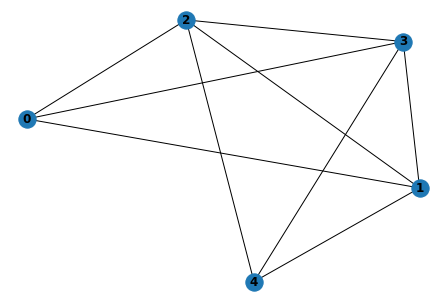

In [6]:
nx.draw(G, with_labels=True, font_weight='bold')

To put together multiple pentagons, the following function is used:

In [7]:
def schapiro_graph(n_pentagons=3, weight=1):
    """Creates the full schapiro graph that is a collection of pentagon nodes.

    Nodes are numberd in groups of five from ``0`` to ``n_pentagons * 5``.

    Parameters
    ----------
    n_pentagons : int (optional)
    	Number of pentagons to include in the graph

    weight : int (optional)
    	Weight of edges.

    Returns
    -------
    G : nx.Graph
    	Graph that contains the nodes and edges for the full schapiro graph
    """    
    G = nx.Graph()

    # Add each community to the full graph
    pents = [schapiro_pentagon(offset=i*5) for i in range(n_pentagons)]
    [G.add_edges_from(pent.edges, weight=weight) for pent in pents]

    # Connect each community together
    for i in range(n_pentagons-1):
        G.add_edge(list(pents[i])[0], list(pents[i-1])[-1], weight=weight)
        G.add_edge(list(pents[i])[4], list(pents[i+1])[0], weight=weight)

    return G

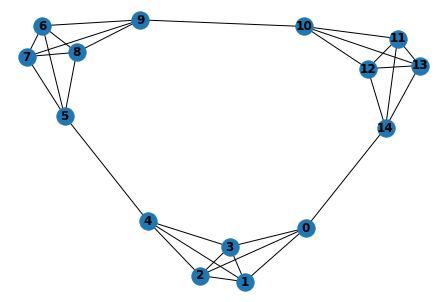

In [8]:
G = schapiro_graph()
nx.draw(G, with_labels=True, font_weight='bold')

Note that each node is numbered, as a way to index them. Additionally, you can create graphs with an arbitrary number of pentagons (communities).

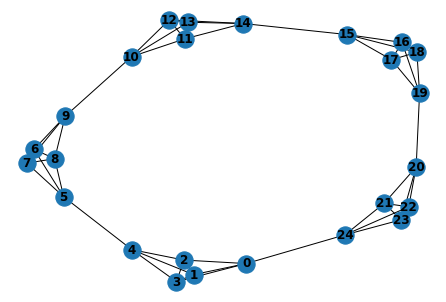

In [9]:
G = schapiro_graph(n_pentagons=5)
nx.draw(G, with_labels=True, font_weight='bold')

## Graph Walks

Sampling from the graph amounts to performing various walks on it. The two that will be used is the random walk, and the Eulerian walk.

### Random Walk

Below is the code for performing a random walk:

In [10]:
@nx.utils.py_random_state(1)
def weighted_sample(node, seed=None):
    """Slightly modified version of ``nx.utils.weighted_choice`` to handle views

    Parameters
    ----------
    node : AtlasView
        A view of a node, containing all its neighbors
        
    Returns
    -------
    step : tuple
        Identifier for the sampled node
    """
    # use roulette method
    rnd = seed.random() * sum([n['weight'] for n in node.values()])
    for k, w in node.items():
        rnd -= w['weight']
        if rnd < 0:
            return k

def walk_random(G, source=None, steps=None):
    """Iterator that yields the start and final position after each step

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    steps : int or None (optional)
    	Number of steps to take before terminating. Yields indefinitely if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """
    # Choose a start position
    source = source or list(G.nodes)[np.random.choice(len(G.nodes))]
    assert source in list(G.nodes)

    # Keep taking steps indefinitely or until steps reaches zero
    while steps != 0:
        position = weighted_sample(G[source])
        yield source, position
        source = position
        if isinstance(steps, (int, float)):
            steps -= 1

### Walk Generator

Below is an example of the random walk:

In [11]:
G = schapiro_graph()
walk = walk_random(G)

for i in range(5):
    print(next(walk))

(4, 2)
(2, 3)
(3, 2)
(2, 0)
(0, 3)


Note that `walk_random` is a generator function, which outputs a generator `walk` which can be iterated through. If not reinstatiated, the generator resumes from the previous location, rather than starting again.

In [12]:
for i in range(5):
    print(next(walk))

(3, 4)
(4, 3)
(3, 0)
(0, 1)
(1, 4)


### Starting (Source) Position

Passing in `source` selects the starting position of the walk:

In [13]:
walk = walk_random(G, source=5)

for i in range(5):
    print(next(walk))

(5, 7)
(7, 9)
(9, 10)
(10, 13)
(13, 12)


### Number of Steps

Previous examples would iterate indefinitely hence the need for explicitly setting the number of steps in the for loop. The generator can be set to end iterating after `steps` number of steps, which means it can be iterated through more directly:

In [14]:
walk = walk_random(G, steps=5)

for step in walk:
    print(step)

(14, 12)
(12, 14)
(14, 11)
(11, 13)
(13, 12)


### Eulerian Walk

In the paper, the participants were tested on Hamiltonian walks (visits every node once). However being able to evaluate every transition of the graph would be more informative, so I implement a bidirectional eulerian walk, which visits every edge twice; once in each direction. This allows for every pair of representations to be compared in each direction. Below is the code for this walk:

In [15]:
def walk_eulerian(G, source=None):
    """Iterator that yields the start and final position after each step on a
    eulerian walk (visit every edge once).

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """    
    source = source or list(G.nodes)[np.random.choice(len(G.nodes))]
    assert source in list(G.nodes)
    
    return nx.algorithms.euler.eulerian_path(G, source=source)

def walk_bi_eulerian(G, source=None):
    """Iterator that yields the start and final position after each step on a
    bidirectional eulerian walk (visit every edge twice; once in each 
    direction).

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """    
    walk = walk_eulerian(G, source=source)
    reverse_walk = []
    # Forward
    for step in walk:
        yield step
        reverse_walk.append(step)
    # Reverse
    for step in reversed(reverse_walk):
        yield tuple(reversed(step))

In [16]:
walk = walk_bi_eulerian(G)

for i, step in enumerate(walk):
    print(step, '<- Reversal' if i==30 else '')

(13, 14) 
(14, 12) 
(12, 13) 
(13, 11) 
(11, 12) 
(12, 10) 
(10, 11) 
(11, 14) 
(14, 0) 
(0, 3) 
(3, 4) 
(4, 2) 
(2, 3) 
(3, 1) 
(1, 2) 
(2, 0) 
(0, 1) 
(1, 4) 
(4, 5) 
(5, 8) 
(8, 9) 
(9, 7) 
(7, 8) 
(8, 6) 
(6, 7) 
(7, 5) 
(5, 6) 
(6, 9) 
(9, 10) 
(10, 13) 
(13, 10) <- Reversal
(10, 9) 
(9, 6) 
(6, 5) 
(5, 7) 
(7, 6) 
(6, 8) 
(8, 7) 
(7, 9) 
(9, 8) 
(8, 5) 
(5, 4) 
(4, 1) 
(1, 0) 
(0, 2) 
(2, 1) 
(1, 3) 
(3, 2) 
(2, 4) 
(4, 3) 
(3, 0) 
(0, 14) 
(14, 11) 
(11, 10) 
(10, 12) 
(12, 11) 
(11, 13) 
(13, 12) 
(12, 14) 
(14, 13) 


## Pytorch Datastructures

The code above is brought together to create `pytorch` datasets for training. Below is the code that has it all together:

In [17]:
class SchapiroFractalsDataset(IterableDataset):
    modes = set(('random', 'eulerian', 'bi_eulerian' 'custom'))
    def __init__(self, batch_size=128, n_pentagons=3, max_steps=256, n_paths=1,
                 mapping=None, mode='random', custom_path=None, debug=False, 
                 dir_data=None, verbose=False):
        """IterableDataset class that returns batches of steps through a
        defined Schapiro graph.

        Parameters
        ----------
        batch_size : int (optional)
            Batch size to be returned
            
        n_pentagons : int (optional)
            Number of pentagons to include in the graph
            
        max_steps : int (optional)
            Max number of steps per walk before resampling the start position
            
        n_paths : int (optional)
            Number of independent paths per sequence of inputs. Setting
        	`n_paths=2` and `max_steps=3` for example, creates a full
        	datasequence of length `6`, where the starting position of the walk
        	is resampled at element `3`. If `dir_data` is `None`, this  is the 
            number of independent paths per sequence of inputs per `epoch` of
            data
            
        mapping : dict or None (optional)
            Mapping from nodes to base elements. If this is `None` and
        	`data_dir` is a valid directory, then a random assignment is created
        	between nodes and files in the directory. If they are both `None`,
        	then the mapping is kept at `None`
            
        mode : str (optional)
            Mode for walking through the graph. Valid modes are set in the
        	`modes` class argument
            
        custom_path : Iterable (optional)
            An iterable containing the desired path to iterate through. Returns
            mapped elements of the path. Requires `mode == 'custom'` and
            `mapping != None`
            
        debug : bool (optional)
            Returns the node elements instead of the mapped elements as a
        	debugging tool
            
        dir_data : pathlib.Path or None (optional)
            Directory where the desired mapped data is
            
        verbose : bool (optional)    
            Increase verbosity
        """
        super().__init__()
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mode = mode
        self.custom_path = custom_path
        self.debug = debug
        self.verbose = True if self.debug else verbose

        self.dir_data = dir_data
        if self.dir_data is not None:
            assert self.dir_data.exists()        

        assert self.mode in self.modes
        if self.mode == 'custom':
            assert self.custom_path is not None and self.isiterable(
                self.custom_path)
            assert mapping is not None # Mapping the input
            self.batch_size = 1
            self.n_paths = 1
            self.max_steps = len(self.custom_path)

        self.G = schapiro_graph(n_pentagons=n_pentagons)            

        self.mapping = mapping or self.random_mapping(self.dir_data,
                                                      self.n_pentagons,
                                                      self.G)
        if self.mapping and self.verbose:
            print(f'Created mapping as follows:\n{self.mapping}')
        
        self.array_data = self.load_node_stimuli()
        
        if not self.array_data or self.debug:
            self.sample_transform = lambda sample : sample
        else:
            self.sample_transform = lambda sample : self.array_data[sample]
        
    def load_node_stimuli(self, suffix=None):
        if self.mapping:
            suffix = suffix or '.tiff'
            # Load the fractal images into memory            
            return {node : ImageOps.grayscale(Image.open(
                str(self.dir_data/(name + suffix))))
                    for node, name in self.mapping.items()
            }
        else:
            return None
        
    def iter_single_sample(self):
        """Creates a single walk generator and returns each element"""
        if self.mode == 'random':
            iter_walk = walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'eulerian':
            iter_walk = walk_eulerian(self.G)
        elif self.mode == 'bi_eulerian':
            iter_walk = walk_bi_eulerian(self.G)
        elif self.mode == 'custom':
            iter_walk = [[s] for s in self.custom_path]

        for sample in iter_walk:
            yield self.sample_transform(sample[0]), sample[0]
        
    def iter_batch_sample(self):
        """Creates a batch of walk generators, and returns each element 
        in a batch"""
        iter_batch = zip(*[self.iter_single_sample()
                           for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):
        """Creates a full dataset of walk generators, and returns each 
        batch"""
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()

    @staticmethod
    def random_mapping(dir_data, n_pentagons=3, G=None):
        if dir_data is not None:
            dir_data = Path(dir_data)
            paths_all_data = list(dir_data.iterdir())
            np.random.shuffle(paths_all_data)
            paths_mapping_data = paths_all_data[:5*n_pentagons]

            if not G:
                G = graph.schapiro_graph(n_pentagons=n_pentagons)

            return {node : path.stem
                    for node, path in zip(range(len(G.nodes)),
                                          paths_mapping_data)}
        else:
            return None

    @staticmethod
    def isiterable(obj):
        """Method that determines if an object is an iterable, not including 
        str.

        Parameters
        ----------
        obj : object
            Object to test if it is an iterable.

        Returns
        -------
        bool : bool
            True if the obj is an iterable, False if not.
        """
        if isinstance(obj, str):
            return False
        else:
            return isinstance(obj, Iterable)

Which can be used as follows:

In [18]:
epochs = 2
batch_size = 4
max_steps = 5
n_paths = 2
verbose = True

iter_ds = SchapiroFractalsDataset(
    batch_size=batch_size,
    max_steps=max_steps,
    n_paths=n_paths,
    verbose=verbose,
)
loader = DataLoader(iter_ds, batch_size=None)
# Note batch_size is set to None bc we are handling it in the dataset

for e in range(epochs):
    print(f'Epoch: {e}')
    for i, (sample, node) in enumerate(loader):
        print(f'Batch: {i}')
        print(sample)

Epoch: 0
Batch: 0
tensor([[ 7,  5,  4,  2,  3],
        [14, 12, 13, 11, 13],
        [10, 12, 10, 13, 12],
        [ 1,  0,  2,  1,  3]])
Batch: 1
tensor([[10, 13, 10, 11, 13],
        [12, 13, 10, 13, 12],
        [ 0,  3,  0, 14,  0],
        [10, 11, 13, 11, 10]])
Epoch: 1
Batch: 0
tensor([[ 2,  0,  1,  2,  3],
        [ 4,  2,  0,  1,  2],
        [11, 13, 12, 10, 11],
        [ 9,  8,  5,  6,  9]])
Batch: 1
tensor([[ 7,  9, 10, 12, 11],
        [ 5,  8,  9, 10, 13],
        [ 1,  3,  0,  3,  4],
        [ 9,  7,  8,  9, 10]])


In this example, each batch is of dimension `[batch_size x max_steps]`, where there are `n_paths` batches. However in the case where the data is not a scalar, the dimensions of each batch will be `[batch_size x input_dim]`, where there are `max_steps*n_paths` batches in the epoch. See this example from a previous notebook:

```
Input[0]:

    epochs = 2
    batch_size = 2
    max_steps = 3
    n_paths = 2

    iter_ds = schapiro.ShapiroResnetEmbeddingDataset(
        batch_size=batch_size,
        max_steps=max_steps,
        n_paths=n_paths,
    )
    loader = DataLoader(iter_ds, batch_size=None)

    epochs = 2
    for e in range(epochs):
        print(f'Epoch: {e}')
        for i, (sample, node) in enumerate(loader):
            print(f'Batch: {i}')
            print(sample.shape)
        
Output[0]:

    Epoch: 0
    Batch: 0
    torch.Size([2, 2048])
    Batch: 1
    torch.Size([2, 2048])
    Batch: 2 
    torch.Size([2, 2048])
    Batch: 3
    torch.Size([2, 2048])
    Batch: 4
    torch.Size([2, 2048])
    Batch: 5 
    torch.Size([2, 2048])
    Epoch: 1
    Batch: 0
    torch.Size([2, 2048])
    Batch: 1
    torch.Size([2, 2048])
    Batch: 2 
    torch.Size([2, 2048])
    Batch: 3
    torch.Size([2, 2048])
    Batch: 4
    torch.Size([2, 2048])
    Batch: 5 
    torch.Size([2, 2048])
```

Depending on your data, may want to change the way the dimensions are handled. Changes likely need to be made here:

```
    def iter_batch_dataset(self):
        """Creates a full dataset of walk generators, and returns each 
        batch"""
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
```

### Pytorch-Lightning

The following methods can be added to make the dataset `pytorch-lightning` compatible:

In [19]:
class LitSchapiroFractalsDataset(SchapiroFractalsDataset):
    @classmethod
    def prepare_data(cls, datamodule, val=False):
        pass
    
    @classmethod
    def setup_data(cls, hparams, datamodule, val=False):
        datamodule.ds = datamodule.ds or cls(
            batch_size=hparams.batch_size,
            n_pentagons=hparams.n_pentagons, 
            max_steps=hparams.max_steps, 
            n_paths=hparams.n_paths,
            mapping=eval(hparams.mapping), # This is a str in hparams
        )
        datamodule.ds_val = datamodule.ds_val or cls(
            n_pentagons=hparams.n_pentagons,
            batch_size=hparams.batch_size, 
            n_paths=hparams.n_val,
            max_steps=hparams.max_steps, 
            mapping=eval(hparams.mapping),
            mode='custom' if hparams.val_path else 'euclidean',
            custom_path=eval(hparams.val_path),
        )

    @staticmethod
    def train_dataloader(hparams, datamodule, ds):
        return DataLoader(ds, 
                          batch_size=None,
                          num_workers=hparams.n_workers)
    
    @staticmethod
    def val_dataloader(hparams, datamodule, ds_val):
        return DataLoader(ds_val, 
                          batch_size=None,
                          num_workers=hparams.n_workers)